# Telecom X - Modelos Predictivos de Machine Learning para Churn

## Descripción del Proyecto - Parte 2
Esta es la **Parte 2** del desafío Telecom X, enfocada en el desarrollo de **modelos predictivos de machine learning** para predecir qué clientes tienen mayor probabilidad de cancelar sus servicios (churn).

Utilizando los datos ya analizados y limpiados en la Parte 1, implementaremos un pipeline robusto de machine learning que incluye:
- Preparación avanzada de datos (encoding, balanceo, normalización)
- Análisis de correlación y selección de variables
- Desarrollo de múltiples modelos predictivos
- Evaluación comparativa con métricas especializadas
- Interpretación de resultados y estrategias de negocio

## Metodología de Machine Learning
Seguiremos una metodología estructurada:
1. **Preparación de Datos**: Encoding, balanceo de clases, normalización
2. **Análisis de Correlación**: Selección de variables predictivas
3. **Modelado**: Implementación de múltiples algoritmos
4. **Evaluación**: Métricas especializadas para clasificación
5. **Interpretación**: Análisis de importancia y estrategias

---

## 1. PREPARACIÓN DE DATOS PARA MACHINE LEARNING
### Carga de datos tratados y preparación del pipeline

In [1]:
# Importación de librerías para machine learning
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import requests
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve
from sklearn.utils import resample
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

plt.style.use('default')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 10

print("Librerías importadas exitosamente")

Librerías importadas exitosamente


In [2]:
# Extracción de datos desde la API (mismos datos de la Parte 1)
url = 'https://raw.githubusercontent.com/ingridcristh/challenge2-data-science-LATAM/main/TelecomX_Data.json'

try:
    response = requests.get(url)
    response.raise_for_status()
    data_json = response.json()
    print(f"Datos extraídos exitosamente: {len(data_json)} registros")
except Exception as e:
    print(f"Error al extraer datos: {e}")

# Conversión a DataFrame y aplicación de limpieza
df_raw = pd.json_normalize(data_json)

column_mapping = {
    'customer.gender': 'Gender',
    'customer.SeniorCitizen': 'SeniorCitizen',
    'customer.Partner': 'Partner',
    'customer.Dependents': 'Dependents',
    'phone.PhoneService': 'PhoneService',
    'phone.MultipleLines': 'MultipleLines',
    'internet.InternetService': 'InternetService',
    'internet.OnlineSecurity': 'OnlineSecurity',
    'internet.OnlineBackup': 'OnlineBackup',
    'internet.DeviceProtection': 'DeviceProtection',
    'internet.TechSupport': 'TechSupport',
    'internet.StreamingTV': 'StreamingTV',
    'internet.StreamingMovies': 'StreamingMovies',
    'account.Contract': 'Contract',
    'account.PaperlessBilling': 'PaperlessBilling',
    'account.PaymentMethod': 'PaymentMethod',
    'account.tenure': 'tenure',
    'account.Charges.Monthly': 'MonthlyCharges',
    'account.Charges.Total': 'TotalCharges'
}

df = df_raw.rename(columns=column_mapping)

df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
df['TotalCharges'] = df['TotalCharges'].fillna(0)
df['SeniorCitizen'] = df['SeniorCitizen'].map({0: 'No', 1: 'Yes'})
df['Cuentas_Diarias'] = df['MonthlyCharges'] / 30

print(f"Dataset preparado: {df.shape}")
print(f"Distribución de Churn: {df['Churn'].value_counts()}")

Datos extraídos exitosamente: 7267 registros
Dataset preparado: (7267, 22)
Distribución de Churn: Churn
No     5174
Yes    1869
        224
Name: count, dtype: int64


### Eliminación de columnas irrelevantes y preparación para modelado

In [3]:
# Eliminación de columnas irrelevantes para el modelado
columns_to_drop = ['customerID']
df_ml = df.drop(columns=columns_to_drop)

print(f"Columnas eliminadas: {columns_to_drop}")
print(f"Dataset para ML: {df_ml.shape}")
print(f"Columnas disponibles: {list(df_ml.columns)}")

Columnas eliminadas: ['customerID']
Dataset para ML: (7267, 21)
Columnas disponibles: ['Churn', 'Gender', 'SeniorCitizen', 'Partner', 'Dependents', 'customer.tenure', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod', 'MonthlyCharges', 'TotalCharges', 'Cuentas_Diarias']


### Encoding de variables categóricas

In [4]:
# Identificación de variables categóricas y numéricas
categorical_columns = df_ml.select_dtypes(include=['object']).columns.tolist()
categorical_columns.remove('Churn')  # Remover la variable objetivo
numerical_columns = df_ml.select_dtypes(include=['int64', 'float64']).columns.tolist()

print(f"Variables categóricas ({len(categorical_columns)}): {categorical_columns}")
print(f"Variables numéricas ({len(numerical_columns)}): {numerical_columns}")

df_encoded = df_ml.copy()

binary_columns = ['Gender', 'SeniorCitizen', 'Partner', 'Dependents', 'PhoneService', 
                 'PaperlessBilling', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 
                 'TechSupport', 'StreamingTV', 'StreamingMovies']

for col in binary_columns:
    if col in df_encoded.columns:
        if col == 'Gender':
            df_encoded[col] = df_encoded[col].map({'Male': 1, 'Female': 0})
        else:
            df_encoded[col] = df_encoded[col].map({'Yes': 1, 'No': 0})
            df_encoded[col] = df_encoded[col].fillna(0)
            df_encoded.loc[df_encoded[col] == 'No internet service', col] = 0
            df_encoded.loc[df_encoded[col] == 'No phone service', col] = 0

print("Encoding de variables binarias completado")

Variables categóricas (16): ['Gender', 'SeniorCitizen', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod']
Variables numéricas (4): ['customer.tenure', 'MonthlyCharges', 'TotalCharges', 'Cuentas_Diarias']
Encoding de variables binarias completado


In [5]:
# One-hot encoding para variables categóricas nominales
nominal_columns = ['MultipleLines', 'InternetService', 'Contract', 'PaymentMethod']

df_encoded = pd.get_dummies(df_encoded, columns=nominal_columns, drop_first=True)

print(f"One-hot encoding aplicado a: {nominal_columns}")
print(f"Nuevas dimensiones del dataset: {df_encoded.shape}")
print(f"Nuevas columnas creadas: {[col for col in df_encoded.columns if any(nom in col for nom in nominal_columns)]}")

One-hot encoding aplicado a: ['MultipleLines', 'InternetService', 'Contract', 'PaymentMethod']
Nuevas dimensiones del dataset: (7267, 26)
Nuevas columnas creadas: ['MultipleLines_No phone service', 'MultipleLines_Yes', 'InternetService_Fiber optic', 'InternetService_No', 'Contract_One year', 'Contract_Two year', 'PaymentMethod_Credit card (automatic)', 'PaymentMethod_Electronic check', 'PaymentMethod_Mailed check']


In [6]:
# Encoding de la variable objetivo
df_encoded['Churn'] = df_encoded['Churn'].map({'Yes': 1, 'No': 0})

print("Variable objetivo codificada:")
print(df_encoded['Churn'].value_counts())
print(f"\nDataset final para ML: {df_encoded.shape}")
print(f"Tipos de datos:")
print(df_encoded.dtypes.value_counts())

Variable objetivo codificada:
Churn
0.0    5174
1.0    1869
Name: count, dtype: int64

Dataset final para ML: (7267, 26)
Tipos de datos:
float64    10
bool        9
int64       7
Name: count, dtype: int64


### Verificación de proporción de churn y análisis de desbalance

=== ANÁLISIS DE DESBALANCE DE CLASES ===
Distribución absoluta:
No Churn (0): 5174
Churn (1): 1869

Distribución porcentual:
No Churn (0): 73.5%
Churn (1): 26.5%

Ratio de desbalance: 2.77:1


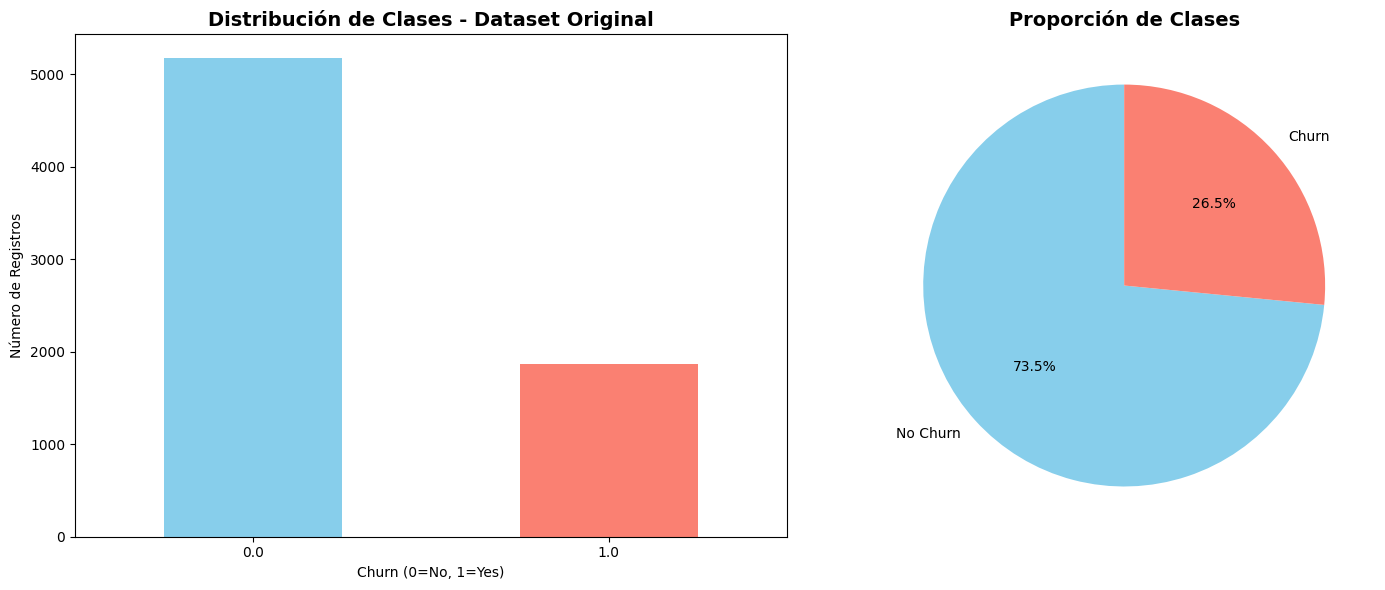


DESBALANCE DETECTADO: Ratio 2.77:1 requiere técnicas de balanceo


In [7]:
# Análisis de desbalance de clases
churn_distribution = df_encoded['Churn'].value_counts()
churn_proportions = df_encoded['Churn'].value_counts(normalize=True) * 100

print("=== ANÁLISIS DE DESBALANCE DE CLASES ===")
print(f"Distribución absoluta:")
print(f"No Churn (0): {churn_distribution[0]}")
print(f"Churn (1): {churn_distribution[1]}")
print(f"\nDistribución porcentual:")
print(f"No Churn (0): {churn_proportions[0]:.1f}%")
print(f"Churn (1): {churn_proportions[1]:.1f}%")

imbalance_ratio = churn_distribution[0] / churn_distribution[1]
print(f"\nRatio de desbalance: {imbalance_ratio:.2f}:1")

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

churn_distribution.plot(kind='bar', ax=ax1, color=['skyblue', 'salmon'])
ax1.set_title('Distribución de Clases - Dataset Original', fontsize=14, fontweight='bold')
ax1.set_xlabel('Churn (0=No, 1=Yes)')
ax1.set_ylabel('Número de Registros')
ax1.tick_params(axis='x', rotation=0)

ax2.pie(churn_distribution.values, labels=['No Churn', 'Churn'], autopct='%1.1f%%', 
        colors=['skyblue', 'salmon'], startangle=90)
ax2.set_title('Proporción de Clases', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

if imbalance_ratio > 2:
    print(f"\nDESBALANCE DETECTADO: Ratio {imbalance_ratio:.2f}:1 requiere técnicas de balanceo")
else:
    print(f"\nDesbalance moderado: Ratio {imbalance_ratio:.2f}:1 - Puede manejarse con métricas apropiadas")

## 2. ANÁLISIS DE CORRELACIÓN Y SELECCIÓN DE VARIABLES
### Matriz de correlación para identificar variables predictivas

=== CORRELACIONES CON CHURN (VALOR ABSOLUTO) ===
customer.tenure                   0.352229
InternetService_Fiber optic       0.308020
Contract_Two year                 0.302253
PaymentMethod_Electronic check    0.301919
InternetService_No                0.227890
TotalCharges                      0.198324
MonthlyCharges                    0.193356
Cuentas_Diarias                   0.193356
PaperlessBilling                  0.191825
Contract_One year                 0.177820
OnlineSecurity                    0.171226
TechSupport                       0.164674
Dependents                        0.164221
SeniorCitizen                     0.150889
Name: Churn, dtype: float64


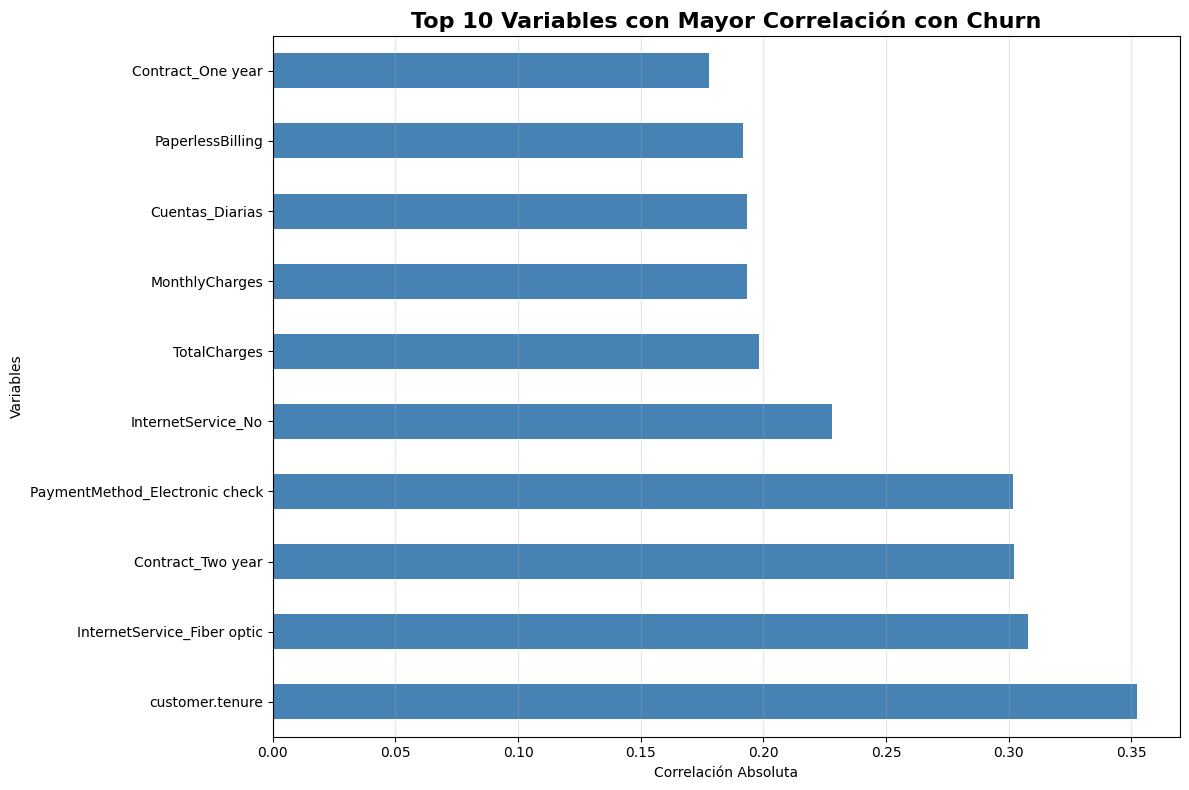


Variables seleccionadas para modelado: ['customer.tenure', 'InternetService_Fiber optic', 'Contract_Two year', 'PaymentMethod_Electronic check', 'InternetService_No', 'TotalCharges', 'MonthlyCharges', 'Cuentas_Diarias', 'PaperlessBilling', 'Contract_One year', 'OnlineSecurity', 'TechSupport', 'Dependents', 'SeniorCitizen', 'Partner']


In [8]:
# Análisis de correlación completo
correlation_matrix = df_encoded.corr()

churn_correlations = correlation_matrix['Churn'].abs().sort_values(ascending=False)

print("=== CORRELACIONES CON CHURN (VALOR ABSOLUTO) ===")
print(churn_correlations[1:15])

top_correlations = churn_correlations[1:11]  # Top 10

plt.figure(figsize=(12, 8))
top_correlations.plot(kind='barh', color='steelblue')
plt.title('Top 10 Variables con Mayor Correlación con Churn', fontsize=16, fontweight='bold')
plt.xlabel('Correlación Absoluta')
plt.ylabel('Variables')
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

important_features = churn_correlations[1:16].index.tolist()  # Top 15
print(f"\nVariables seleccionadas para modelado: {important_features}")

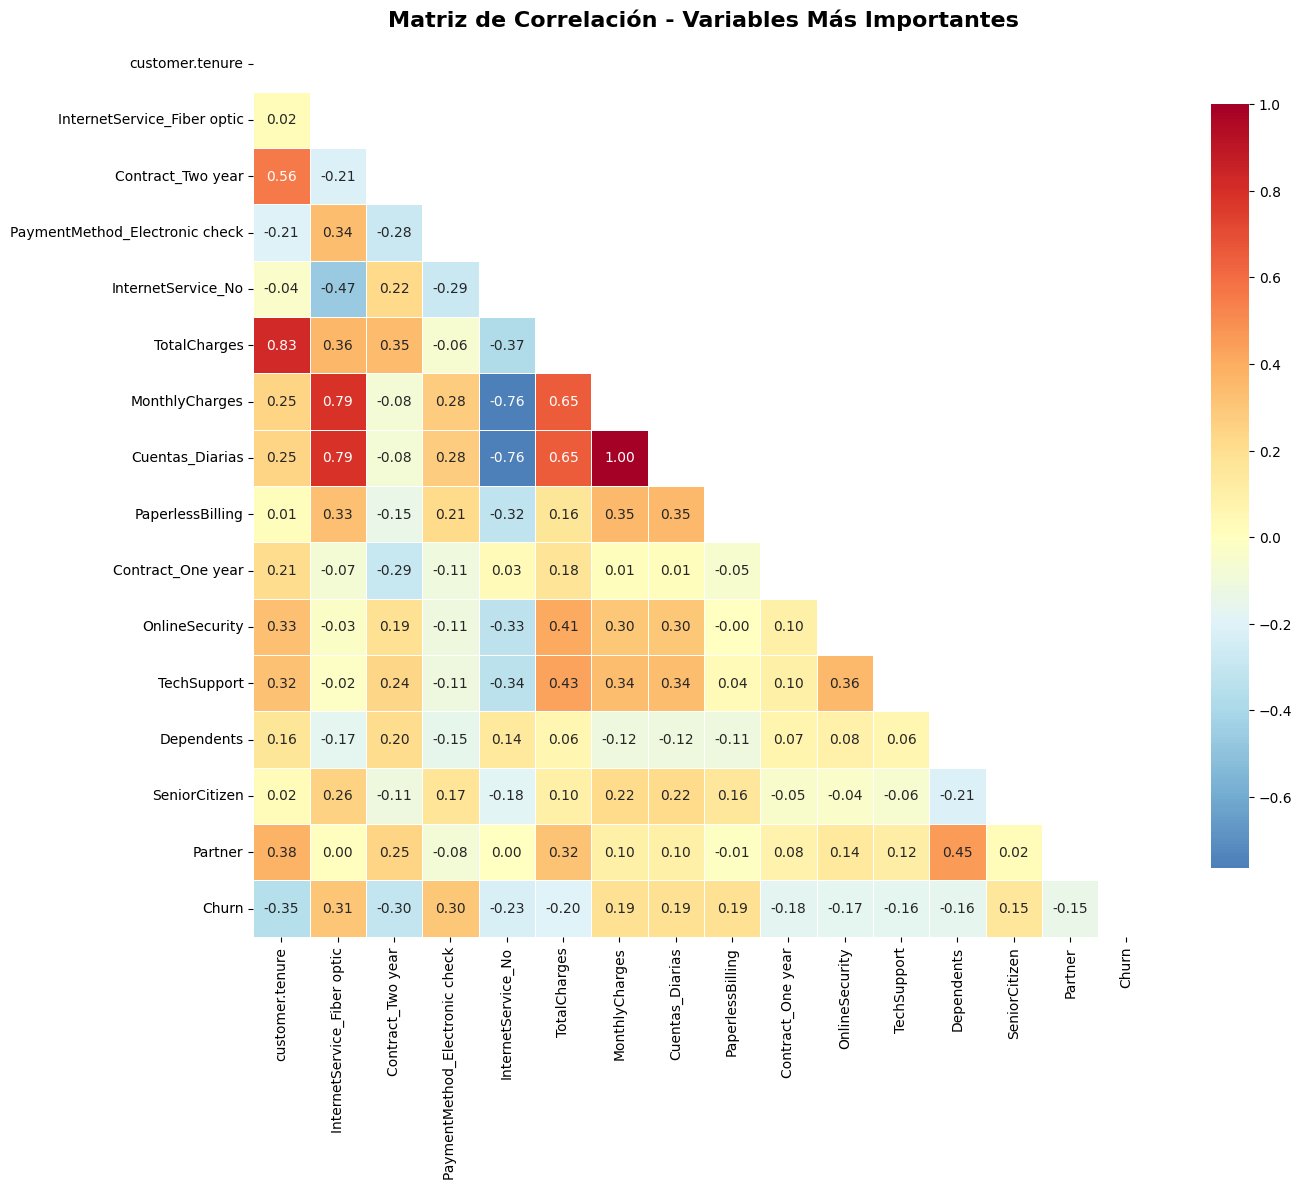

In [9]:
# Matriz de correlación visual para variables importantes
important_vars_with_target = important_features + ['Churn']
correlation_subset = df_encoded[important_vars_with_target].corr()

plt.figure(figsize=(14, 12))
mask = np.triu(np.ones_like(correlation_subset, dtype=bool))
sns.heatmap(correlation_subset, mask=mask, annot=True, cmap='RdYlBu_r', center=0,
            square=True, linewidths=0.5, cbar_kws={"shrink": .8}, fmt='.2f')
plt.title('Matriz de Correlación - Variables Más Importantes', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

### Análisis dirigido con visualizaciones específicas

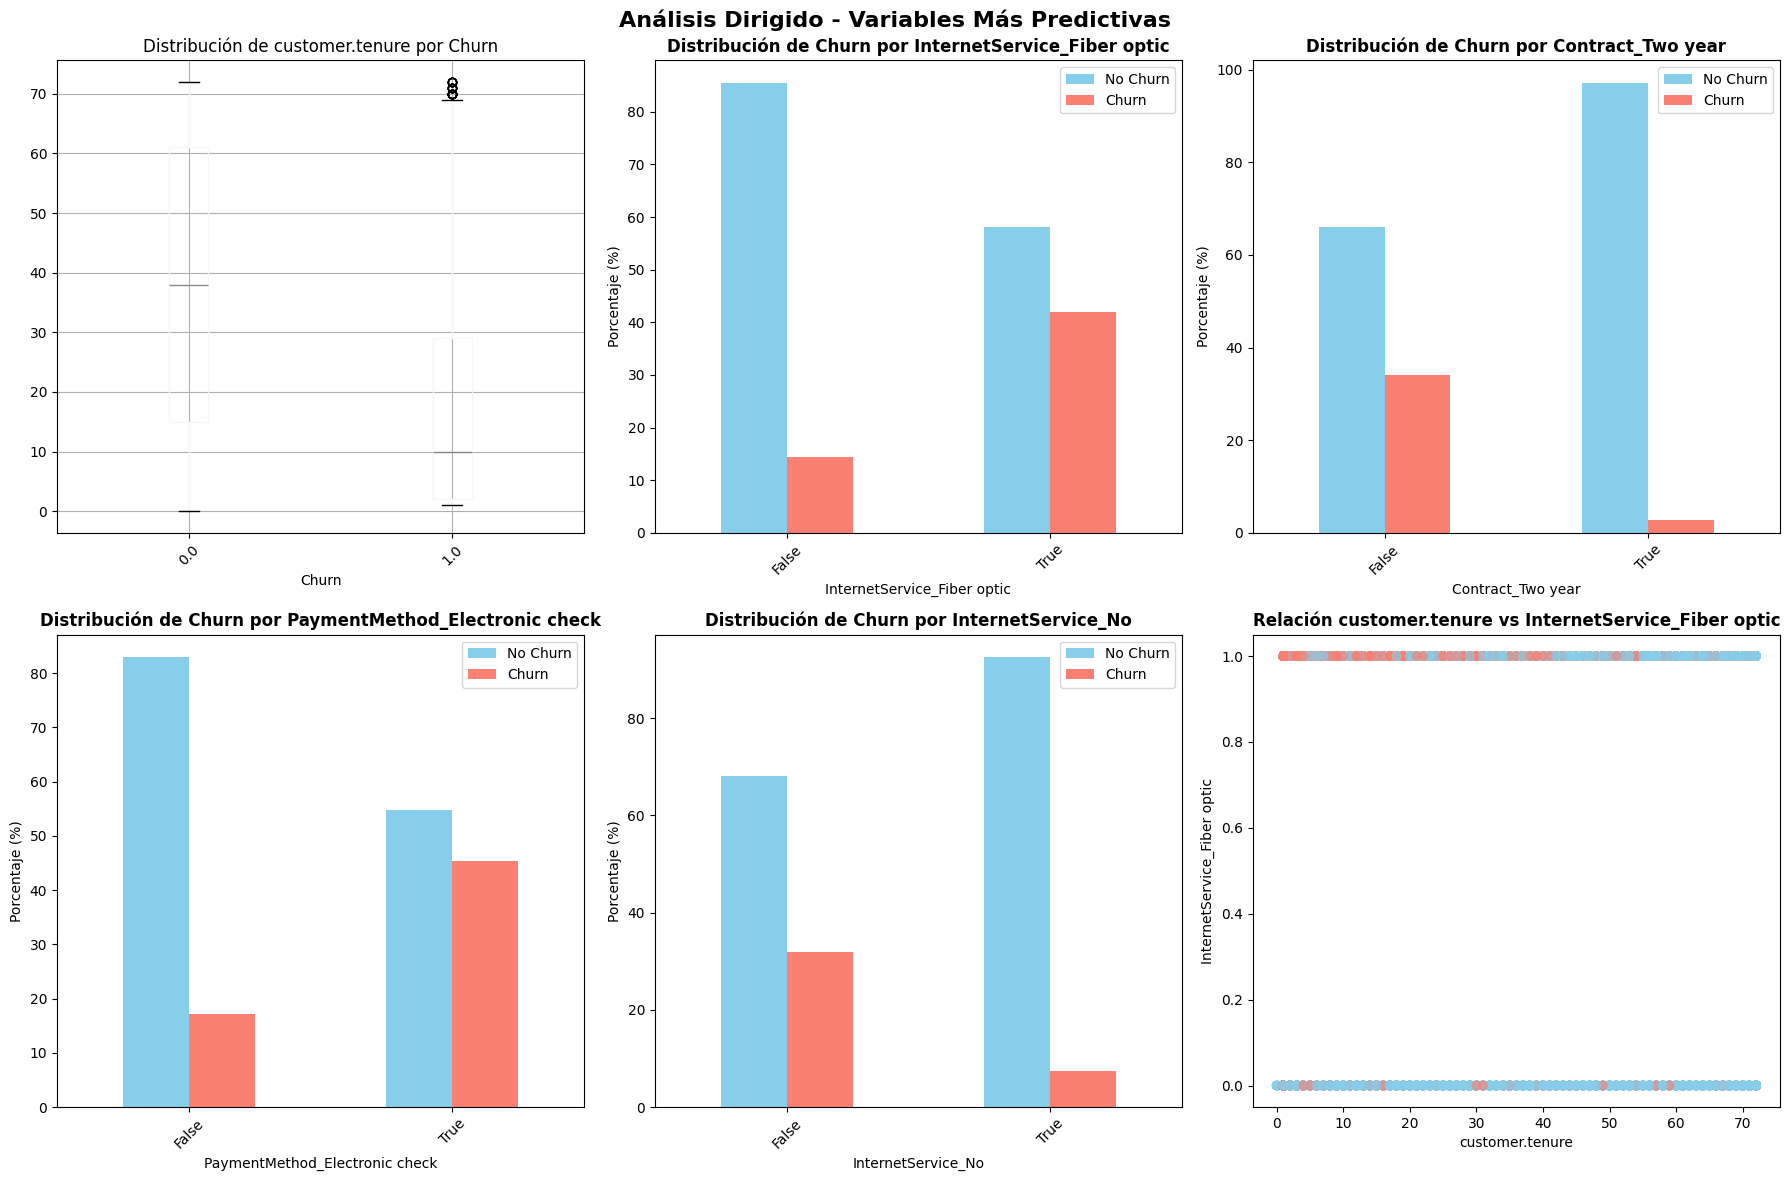

In [10]:
# Análisis dirigido de las variables más correlacionadas
top_5_features = churn_correlations[1:6].index.tolist()

fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.ravel()

for i, feature in enumerate(top_5_features):
    if i < 5:
        if df_encoded[feature].nunique() <= 10:
            crosstab = pd.crosstab(df_encoded[feature], df_encoded['Churn'], normalize='index') * 100
            crosstab.plot(kind='bar', ax=axes[i], color=['skyblue', 'salmon'])
            axes[i].set_title(f'Distribución de Churn por {feature}', fontweight='bold')
            axes[i].set_ylabel('Porcentaje (%)')
            axes[i].legend(['No Churn', 'Churn'])
        else:
            df_encoded.boxplot(column=feature, by='Churn', ax=axes[i])
            axes[i].set_title(f'Distribución de {feature} por Churn')
        
        axes[i].tick_params(axis='x', rotation=45)

if len(top_5_features) >= 2:
    scatter_data = df_encoded[[top_5_features[0], top_5_features[1], 'Churn']]
    colors = ['skyblue' if x == 0 else 'salmon' for x in scatter_data['Churn']]
    axes[5].scatter(scatter_data[top_5_features[0]], scatter_data[top_5_features[1]], 
                   c=colors, alpha=0.6)
    axes[5].set_xlabel(top_5_features[0])
    axes[5].set_ylabel(top_5_features[1])
    axes[5].set_title(f'Relación {top_5_features[0]} vs {top_5_features[1]}', fontweight='bold')

plt.suptitle('Análisis Dirigido - Variables Más Predictivas', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

## 3. PREPARACIÓN FINAL Y DIVISIÓN DE DATOS
### Separación de características y variable objetivo

In [11]:
# Separación de características (X) y variable objetivo (y)
X = df_encoded.drop('Churn', axis=1)
y = df_encoded['Churn']

print(f"Características (X): {X.shape}")
print(f"Variable objetivo (y): {y.shape}")
print(f"\nPrimeras características: {list(X.columns[:10])}")
print(f"Distribución de y: {y.value_counts()}")

Características (X): (7267, 25)
Variable objetivo (y): (7267,)

Primeras características: ['Gender', 'SeniorCitizen', 'Partner', 'Dependents', 'customer.tenure', 'PhoneService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport']
Distribución de y: Churn
0.0    5174
1.0    1869
Name: count, dtype: int64


In [12]:
# Supongamos que ya tienes X e y definidos

mask = ~y.isna()
X = X[mask]
y = y[mask]

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Conjunto de entrenamiento: {X_train.shape}")
print(f"Conjunto de prueba: {X_test.shape}")

print(f"\nDistribución en entrenamiento:")
print(y_train.value_counts())
print(f"\nDistribución en prueba:")
print(y_test.value_counts())

train_churn_rate = y_train.mean()
test_churn_rate = y_test.mean()
print(f"\nTasa de churn en entrenamiento: {train_churn_rate:.3f}")
print(f"Tasa de churn en prueba: {test_churn_rate:.3f}")
print(f"Diferencia: {abs(train_churn_rate - test_churn_rate):.3f}")

Conjunto de entrenamiento: (5634, 25)
Conjunto de prueba: (1409, 25)

Distribución en entrenamiento:
Churn
0.0    4139
1.0    1495
Name: count, dtype: int64

Distribución en prueba:
Churn
0.0    1035
1.0     374
Name: count, dtype: int64

Tasa de churn en entrenamiento: 0.265
Tasa de churn en prueba: 0.265
Diferencia: 0.000


### Normalización de datos para modelos que lo requieren

In [13]:
# Normalización usando StandardScaler para modelos que lo requieren
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns, index=X_train.index)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns, index=X_test.index)

print("Normalización completada")
print(f"Estadísticas antes de normalización (muestra):")
print(X_train[['customer.tenure', 'MonthlyCharges', 'TotalCharges']].describe())
print(f"\nEstadísticas después de normalización (muestra):")
print(X_train_scaled[['customer.tenure', 'MonthlyCharges', 'TotalCharges']].describe())

Normalización completada
Estadísticas antes de normalización (muestra):
       customer.tenure  MonthlyCharges  TotalCharges
count      5634.000000     5634.000000   5634.000000
mean         32.349663       65.032677   2291.430325
std          24.582641       30.023150   2277.156444
min           0.000000       18.400000      0.000000
25%           9.000000       38.312500    393.225000
50%          29.000000       70.525000   1395.525000
75%          55.000000       89.900000   3832.900000
max          72.000000      118.750000   8684.800000

Estadísticas después de normalización (muestra):
       customer.tenure  MonthlyCharges  TotalCharges
count     5.634000e+03    5.634000e+03  5.634000e+03
mean     -1.891754e-17    1.841307e-16 -3.783508e-17
std       1.000089e+00    1.000089e+00  1.000089e+00
min      -1.316072e+00   -1.553362e+00 -1.006358e+00
25%      -9.499278e-01   -8.900648e-01 -8.336598e-01
50%      -1.362734e-01    1.829525e-01 -3.934665e-01
75%       9.214774e-01    8.28

## 4. MODELADO PREDICTIVO
### Implementación de múltiples algoritmos de machine learning

In [14]:
# Definición de modelos a evaluar
models = {
    'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000),
    'K-Nearest Neighbors': KNeighborsClassifier(n_neighbors=5),

    'Decision Tree': DecisionTreeClassifier(random_state=42, max_depth=10),
    'Random Forest': RandomForestClassifier(random_state=42, n_estimators=100)
}

models_need_scaling = ['Logistic Regression', 'K-Nearest Neighbors']

print(f"Modelos a evaluar: {list(models.keys())}")
print(f"Modelos que requieren normalización: {models_need_scaling}")

Modelos a evaluar: ['Logistic Regression', 'K-Nearest Neighbors', 'Decision Tree', 'Random Forest']
Modelos que requieren normalización: ['Logistic Regression', 'K-Nearest Neighbors']


In [15]:
# Entrenamiento y evaluación de modelos
results = {}
trained_models = {}

print("=== ENTRENAMIENTO DE MODELOS ===")

for name, model in models.items():
    print(f"\nEntrenando {name}...")
    
    if name in models_need_scaling:
        X_train_model = X_train_scaled
        X_test_model = X_test_scaled
    else:
        X_train_model = X_train
        X_test_model = X_test
    
    model.fit(X_train_model, y_train)
    
    y_pred = model.predict(X_test_model)
    y_pred_proba = model.predict_proba(X_test_model)[:, 1]
    
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred_proba)

    results[name] = {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'roc_auc': roc_auc,
        'predictions': y_pred,
        'probabilities': y_pred_proba
    }
    
    trained_models[name] = model
    
    print(f"{name} entrenado - Accuracy: {accuracy:.3f}, F1: {f1:.3f}, ROC-AUC: {roc_auc:.3f}")

print("\nEntrenamiento completado para todos los modelos")

=== ENTRENAMIENTO DE MODELOS ===

Entrenando Logistic Regression...
Logistic Regression entrenado - Accuracy: 0.794, F1: 0.574, ROC-AUC: 0.843

Entrenando K-Nearest Neighbors...
K-Nearest Neighbors entrenado - Accuracy: 0.749, F1: 0.504, ROC-AUC: 0.776

Entrenando Decision Tree...
Decision Tree entrenado - Accuracy: 0.760, F1: 0.504, ROC-AUC: 0.753

Entrenando Random Forest...
Random Forest entrenado - Accuracy: 0.784, F1: 0.541, ROC-AUC: 0.823

Entrenamiento completado para todos los modelos


## 5. EVALUACIÓN COMPLETA DE MODELOS
### Métricas detalladas y comparación de rendimiento

In [16]:
# Crear DataFrame con resultados para comparación
results_df = pd.DataFrame({
    'Model': list(results.keys()),
    'Accuracy': [results[model]['accuracy'] for model in results.keys()],
    'Precision': [results[model]['precision'] for model in results.keys()],
    'Recall': [results[model]['recall'] for model in results.keys()],
    'F1-Score': [results[model]['f1_score'] for model in results.keys()],
    'ROC-AUC': [results[model]['roc_auc'] for model in results.keys()]
})

results_df = results_df.round(4)

print("=== COMPARACIÓN DE MODELOS ===")
print(results_df.to_string(index=False))

best_accuracy = results_df.loc[results_df['Accuracy'].idxmax(), 'Model']
best_f1 = results_df.loc[results_df['F1-Score'].idxmax(), 'Model']
best_recall = results_df.loc[results_df['Recall'].idxmax(), 'Model']
best_roc_auc = results_df.loc[results_df['ROC-AUC'].idxmax(), 'Model']

print(f"\n=== MEJORES MODELOS POR MÉTRICA ===")
print(f"Mejor Accuracy: {best_accuracy} ({results_df.loc[results_df['Model'] == best_accuracy, 'Accuracy'].values[0]:.4f})")
print(f"Mejor F1-Score: {best_f1} ({results_df.loc[results_df['Model'] == best_f1, 'F1-Score'].values[0]:.4f})")
print(f"Mejor Recall: {best_recall} ({results_df.loc[results_df['Model'] == best_recall, 'Recall'].values[0]:.4f})")
print(f"Mejor ROC-AUC: {best_roc_auc} ({results_df.loc[results_df['Model'] == best_roc_auc, 'ROC-AUC'].values[0]:.4f})")

=== COMPARACIÓN DE MODELOS ===
              Model  Accuracy  Precision  Recall  F1-Score  ROC-AUC
Logistic Regression    0.7942     0.6373  0.5214    0.5735   0.8432
K-Nearest Neighbors    0.7488     0.5294  0.4813    0.5042   0.7756
      Decision Tree    0.7601     0.5584  0.4599    0.5044   0.7528
      Random Forest    0.7842     0.6215  0.4786    0.5408   0.8229

=== MEJORES MODELOS POR MÉTRICA ===
Mejor Accuracy: Logistic Regression (0.7942)
Mejor F1-Score: Logistic Regression (0.5735)
Mejor Recall: Logistic Regression (0.5214)
Mejor ROC-AUC: Logistic Regression (0.8432)


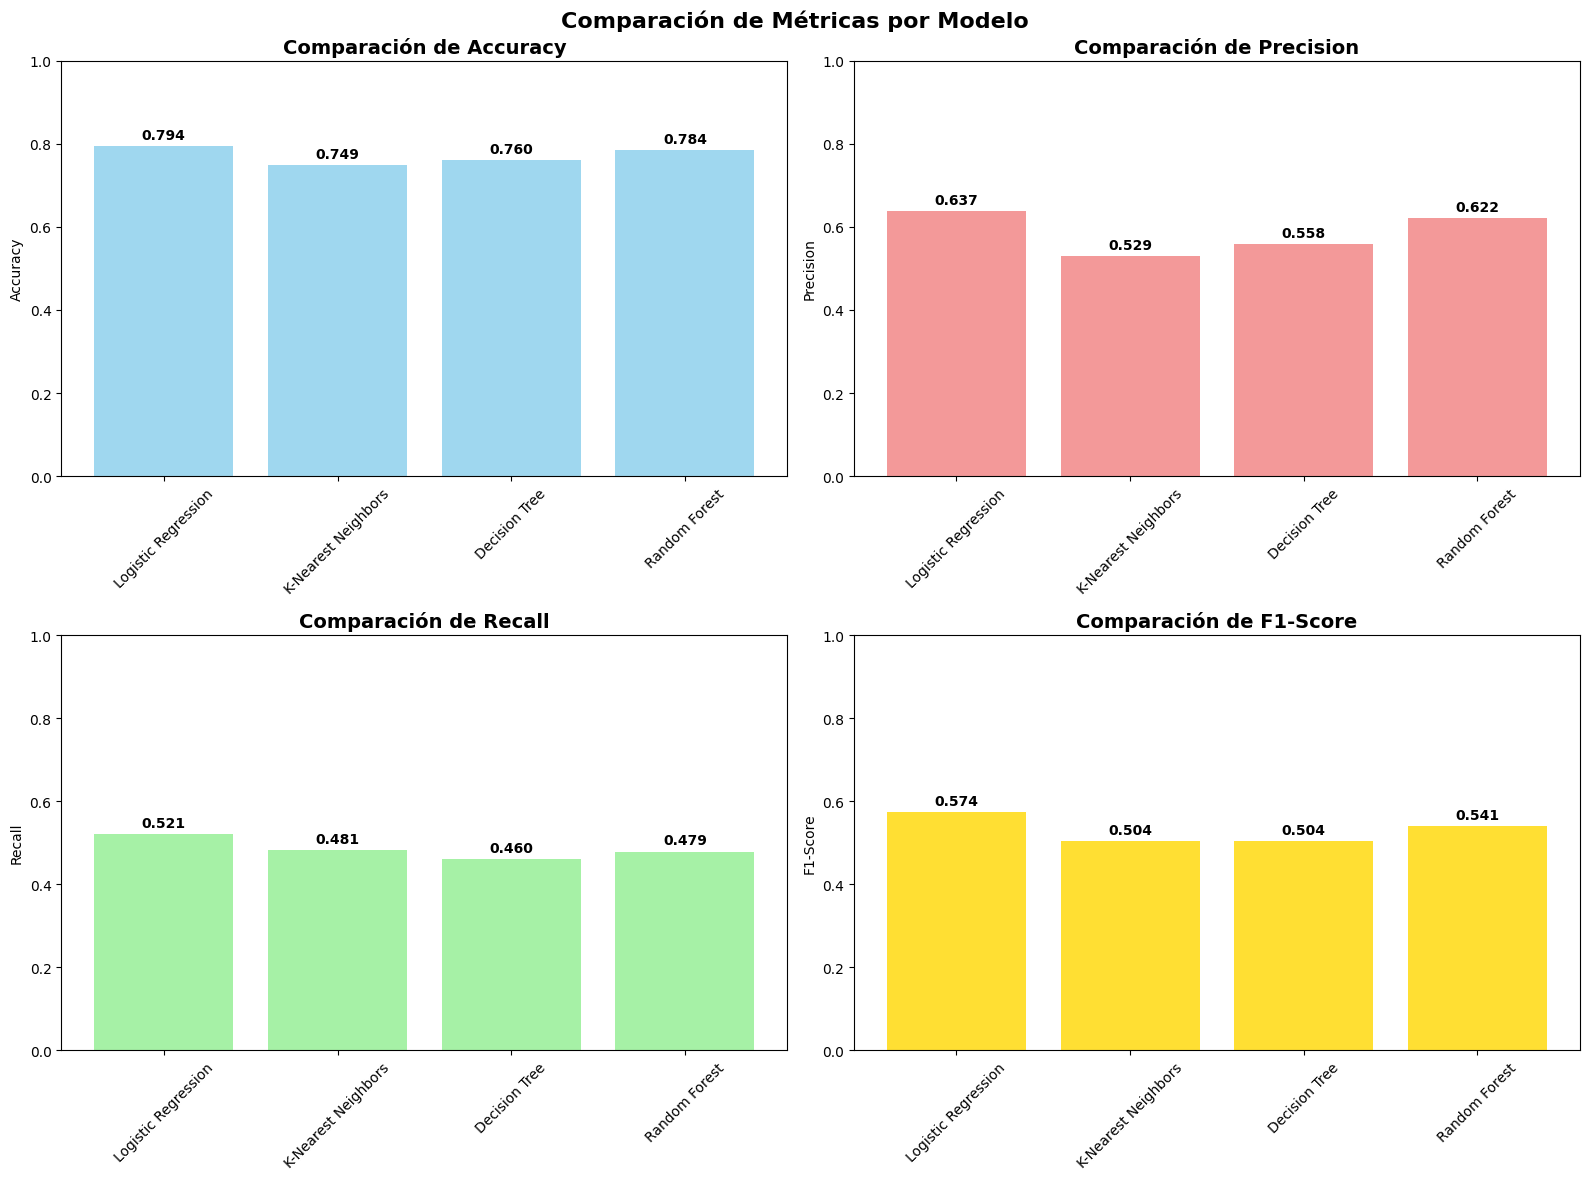

In [17]:
# Visualización comparativa de métricas
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
colors = ['skyblue', 'lightcoral', 'lightgreen', 'gold']

for i, metric in enumerate(metrics):
    ax = axes[i//2, i%2]
    bars = ax.bar(results_df['Model'], results_df[metric], color=colors[i], alpha=0.8)
    ax.set_title(f'Comparación de {metric}', fontsize=14, fontweight='bold')
    ax.set_ylabel(metric)
    ax.set_ylim(0, 1)
    ax.tick_params(axis='x', rotation=45)
    
    for bar, value in zip(bars, results_df[metric]):
        ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
                f'{value:.3f}', ha='center', va='bottom', fontweight='bold')

plt.suptitle('Comparación de Métricas por Modelo', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

### Matrices de confusión para cada modelo

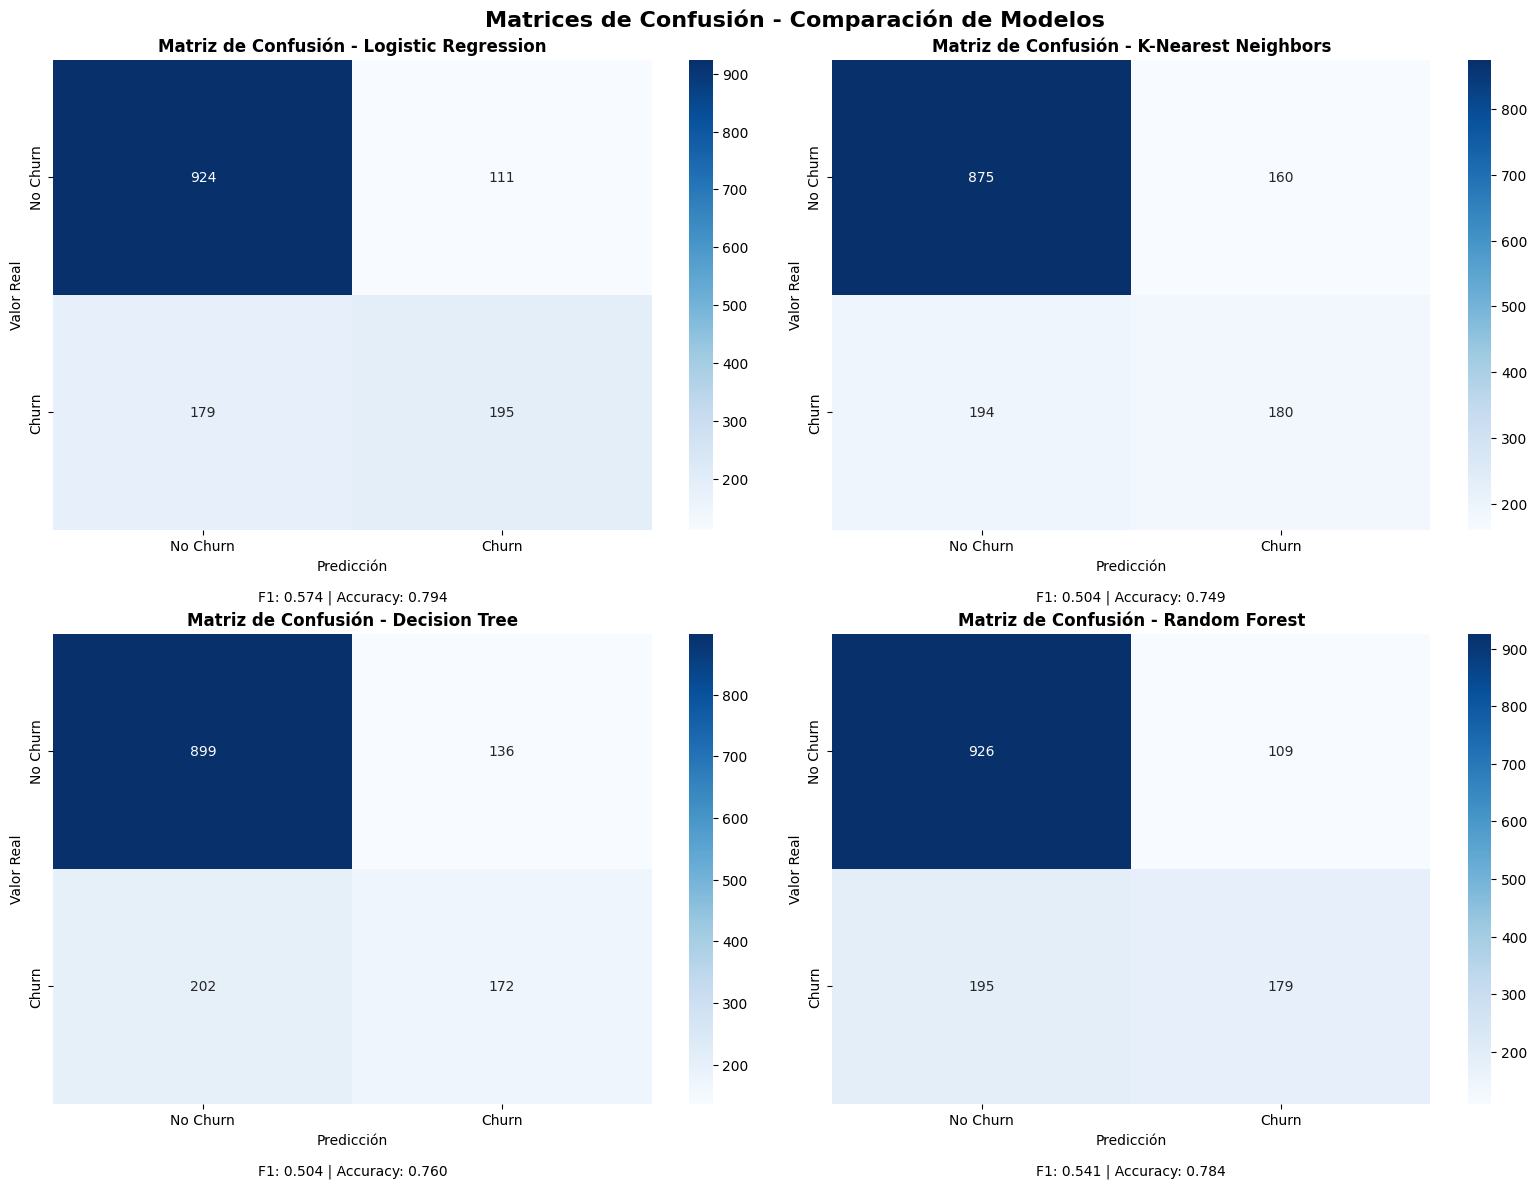

In [18]:
# Matrices de confusión para todos los modelos
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
axes = axes.ravel()

for i, (name, result) in enumerate(results.items()):
    cm = confusion_matrix(y_test, result['predictions'])
    
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[i],
                xticklabels=['No Churn', 'Churn'],
                yticklabels=['No Churn', 'Churn'])
    axes[i].set_title(f'Matriz de Confusión - {name}', fontsize=12, fontweight='bold')
    axes[i].set_xlabel('Predicción')
    axes[i].set_ylabel('Valor Real')
    
    f1 = result['f1_score']
    accuracy = result['accuracy']
    axes[i].text(0.5, -0.15, f'F1: {f1:.3f} | Accuracy: {accuracy:.3f}', 
                transform=axes[i].transAxes, ha='center', fontsize=10)

plt.suptitle('Matrices de Confusión - Comparación de Modelos', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

### Curvas ROC para comparación visual

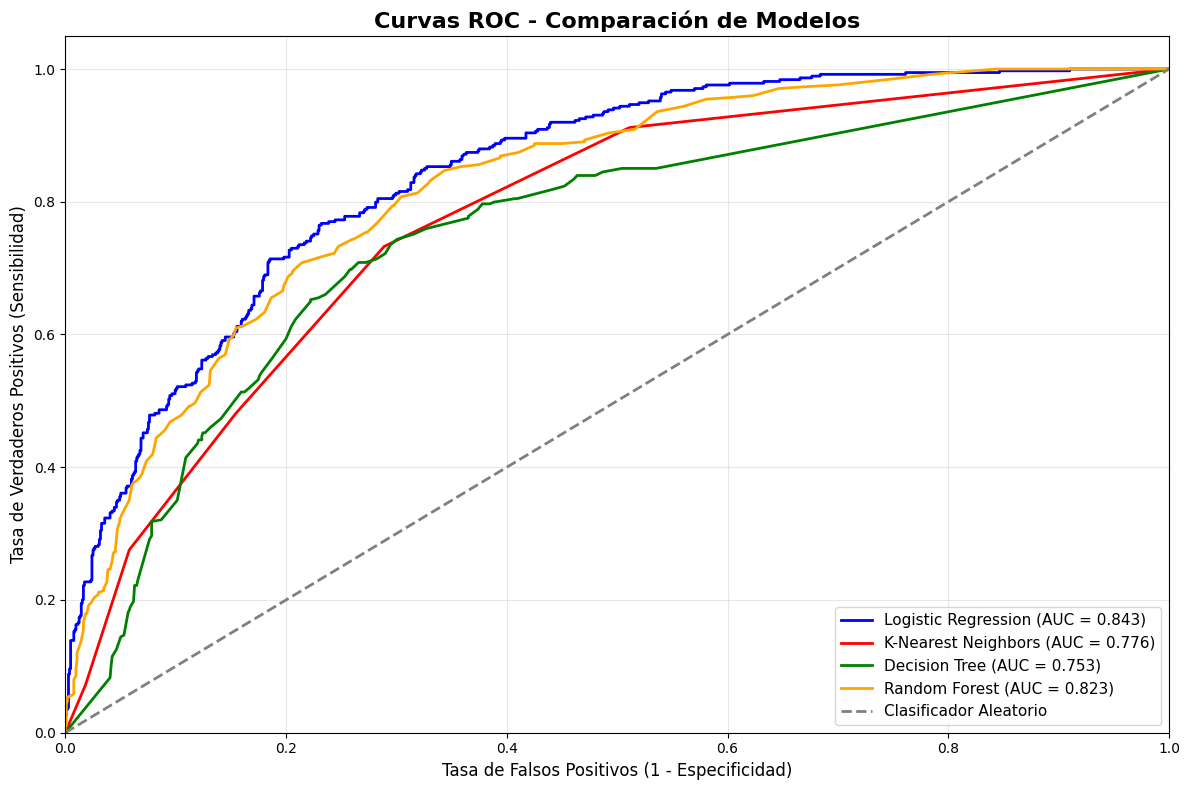

=== INTERPRETACIÓN DE CURVAS ROC ===
- Cuanto más cerca esté la curva de la esquina superior izquierda, mejor es el modelo
- AUC = 0.5: Clasificador aleatorio
- AUC > 0.7: Buen rendimiento
- AUC > 0.8: Excelente rendimiento


In [19]:
# Curvas ROC para todos los modelos
plt.figure(figsize=(12, 8))

colors = ['blue', 'red', 'green', 'orange']

for i, (name, result) in enumerate(results.items()):
    fpr, tpr, _ = roc_curve(y_test, result['probabilities'])
    roc_auc = result['roc_auc']
    
    plt.plot(fpr, tpr, color=colors[i], lw=2, 
             label=f'{name} (AUC = {roc_auc:.3f})')

plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--', label='Clasificador Aleatorio')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de Falsos Positivos (1 - Especificidad)', fontsize=12)
plt.ylabel('Tasa de Verdaderos Positivos (Sensibilidad)', fontsize=12)
plt.title('Curvas ROC - Comparación de Modelos', fontsize=16, fontweight='bold')
plt.legend(loc="lower right", fontsize=11)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

print("=== INTERPRETACIÓN DE CURVAS ROC ===")
print("- Cuanto más cerca esté la curva de la esquina superior izquierda, mejor es el modelo")
print("- AUC = 0.5: Clasificador aleatorio")
print("- AUC > 0.7: Buen rendimiento")
print("- AUC > 0.8: Excelente rendimiento")

## 6. ANÁLISIS DE IMPORTANCIA DE VARIABLES
### Identificación de factores más influyentes en la predicción

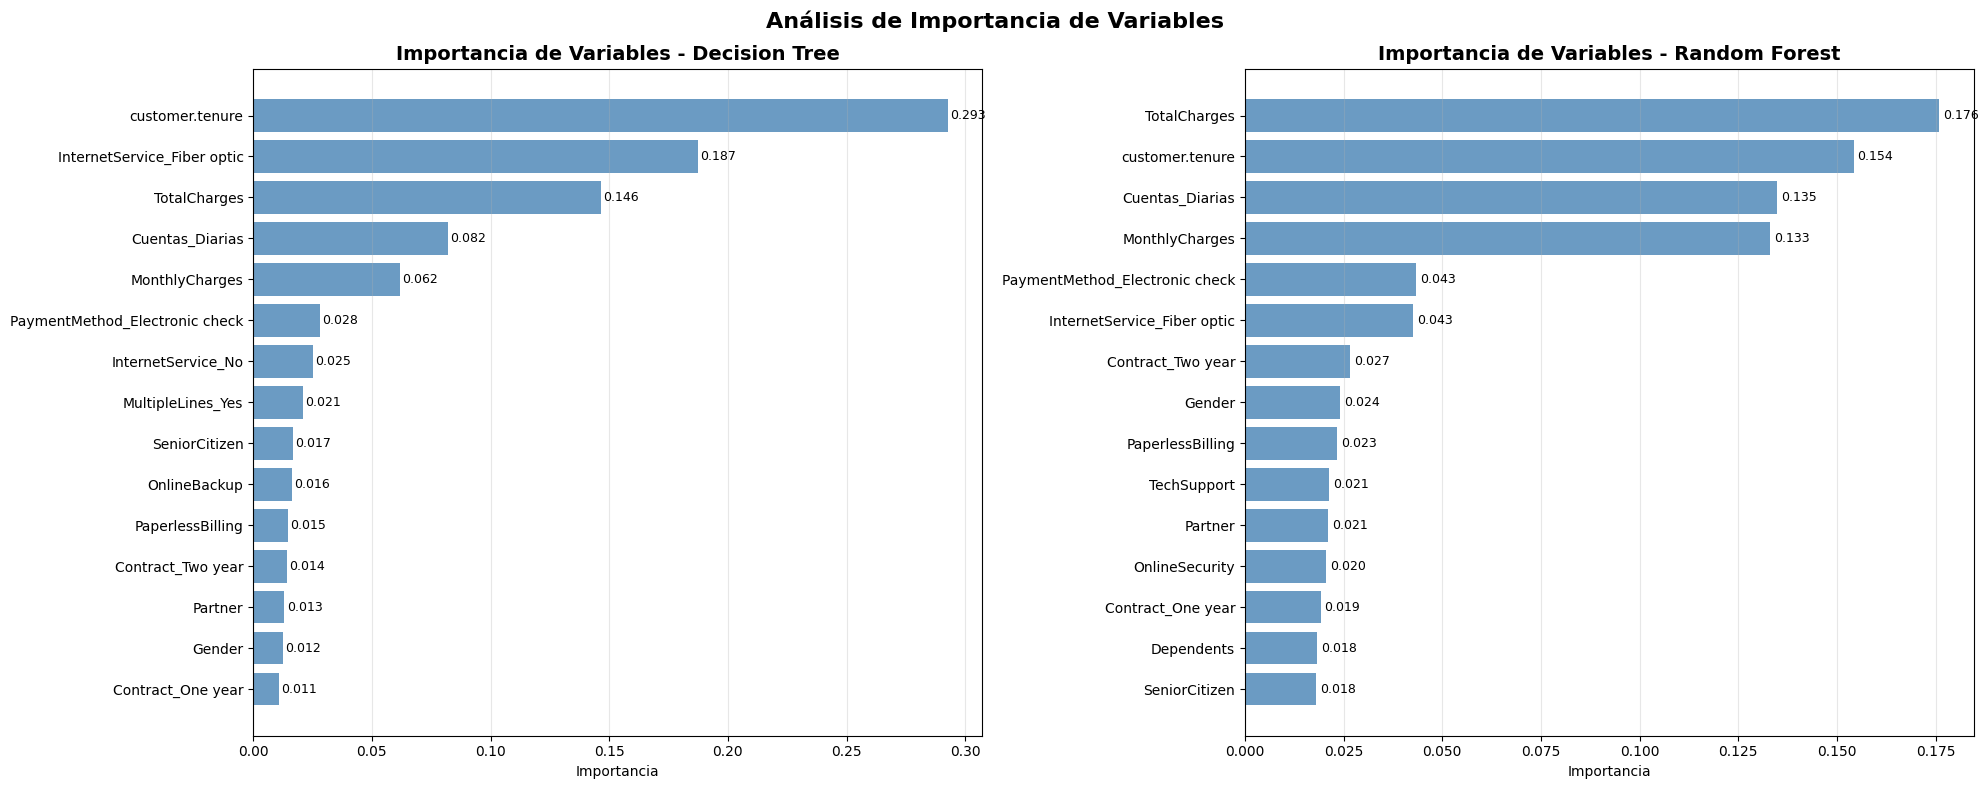

In [20]:
# Análisis de importancia para modelos basados en árboles
tree_models = ['Decision Tree', 'Random Forest']

fig, axes = plt.subplots(1, 2, figsize=(20, 8))

for i, model_name in enumerate(tree_models):
    if model_name in trained_models:
        model = trained_models[model_name]
        
        importances = model.feature_importances_
        feature_names = X_train.columns
        
        importance_df = pd.DataFrame({
            'feature': feature_names,
            'importance': importances
        }).sort_values('importance', ascending=True)
        
        top_15 = importance_df.tail(15)

        axes[i].barh(range(len(top_15)), top_15['importance'], color='steelblue', alpha=0.8)
        axes[i].set_yticks(range(len(top_15)))
        axes[i].set_yticklabels(top_15['feature'])
        axes[i].set_xlabel('Importancia')
        axes[i].set_title(f'Importancia de Variables - {model_name}', fontsize=14, fontweight='bold')
        axes[i].grid(axis='x', alpha=0.3)
        
        for j, (idx, row) in enumerate(top_15.iterrows()):
            axes[i].text(row['importance'] + 0.001, j, f'{row["importance"]:.3f}', 
                        va='center', fontsize=9)

plt.suptitle('Análisis de Importancia de Variables', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

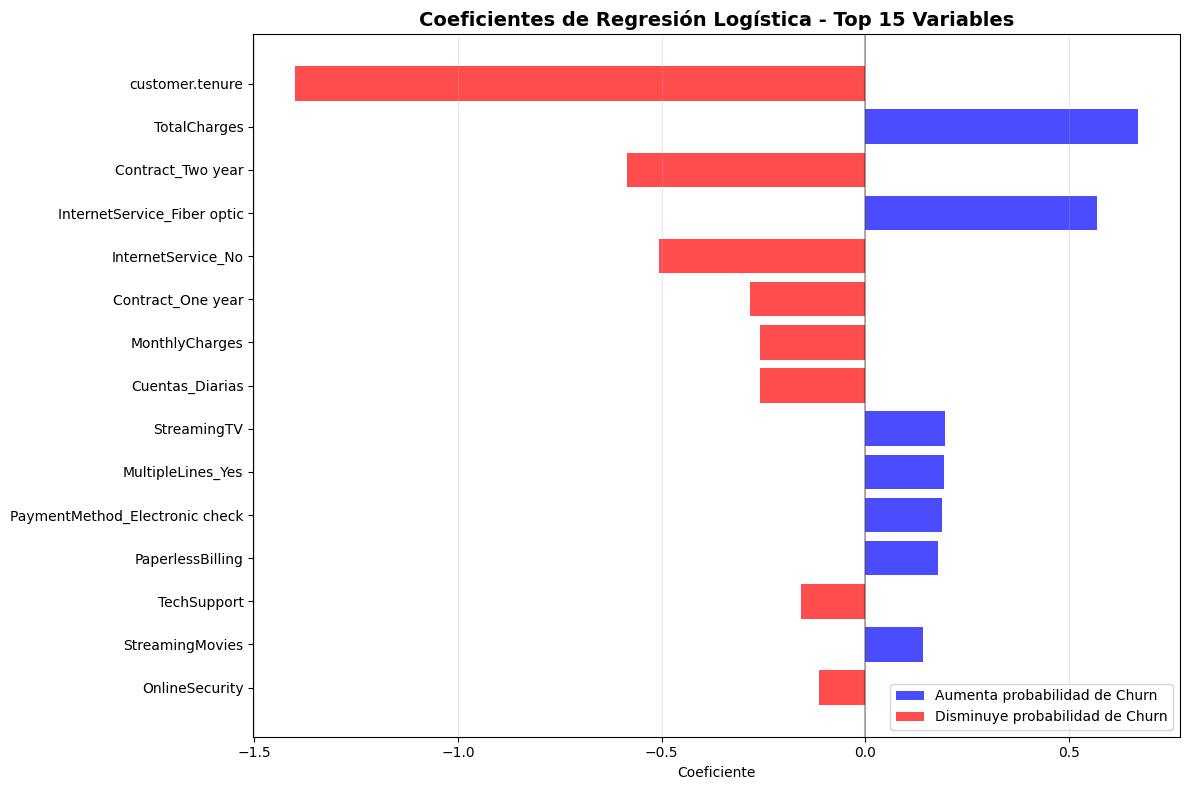

=== TOP 10 VARIABLES MÁS INFLUYENTES (REGRESIÓN LOGÍSTICA) ===
                    feature  coefficient
          MultipleLines_Yes     0.192965
                StreamingTV     0.194523
            Cuentas_Diarias    -0.259123
             MonthlyCharges    -0.259123
          Contract_One year    -0.282354
         InternetService_No    -0.505541
InternetService_Fiber optic     0.569071
          Contract_Two year    -0.585641
               TotalCharges     0.669219
            customer.tenure    -1.399204


In [21]:
# Análisis de coeficientes para Regresión Logística
if 'Logistic Regression' in trained_models:
    lr_model = trained_models['Logistic Regression']
    
    coefficients = lr_model.coef_[0]
    feature_names = X_train.columns
    
    coef_df = pd.DataFrame({
        'feature': feature_names,
        'coefficient': coefficients,
        'abs_coefficient': np.abs(coefficients)
    }).sort_values('abs_coefficient', ascending=True)
    
    top_15_coef = coef_df.tail(15)
    
    plt.figure(figsize=(12, 8))
    colors = ['red' if x < 0 else 'blue' for x in top_15_coef['coefficient']]
    bars = plt.barh(range(len(top_15_coef)), top_15_coef['coefficient'], color=colors, alpha=0.7)
    
    plt.yticks(range(len(top_15_coef)), top_15_coef['feature'])
    plt.xlabel('Coeficiente')
    plt.title('Coeficientes de Regresión Logística - Top 15 Variables', fontsize=14, fontweight='bold')
    plt.axvline(x=0, color='black', linestyle='-', alpha=0.3)
    plt.grid(axis='x', alpha=0.3)
    
    from matplotlib.patches import Patch
    legend_elements = [Patch(facecolor='blue', alpha=0.7, label='Aumenta probabilidad de Churn'),
                      Patch(facecolor='red', alpha=0.7, label='Disminuye probabilidad de Churn')]
    plt.legend(handles=legend_elements, loc='lower right')
    
    plt.tight_layout()
    plt.show()
    
    print("=== TOP 10 VARIABLES MÁS INFLUYENTES (REGRESIÓN LOGÍSTICA) ===")
    print(coef_df.tail(10)[['feature', 'coefficient']].to_string(index=False))

## 7. INTERPRETACIÓN Y CONCLUSIONES ESTRATÉGICAS
### Análisis de resultados y recomendaciones de negocio

In [22]:
# Resumen ejecutivo de resultados de modelos predictivos de churn

print("=" * 80)
print("RESUMEN EJECUTIVO - MODELOS PREDICTIVOS DE CHURN")
print("=" * 80)

results_df['composite_score'] = (
    0.25 * results_df['Accuracy'] + 
    0.25 * results_df['Precision'] + 
    0.30 * results_df['Recall'] +  # Más peso al recall (importante no perder clientes)
    0.20 * results_df['F1-Score']
)

best_overall_idx = results_df['composite_score'].idxmax()
best_overall_model = results_df.loc[best_overall_idx, 'Model']

print(f"\nMEJOR MODELO GENERAL: {best_overall_model}")
print(f"   Score Compuesto: {results_df.loc[best_overall_idx, 'composite_score']:.4f}")
print(f"   Accuracy: {results_df.loc[best_overall_idx, 'Accuracy']:.4f}")
print(f"   Precision: {results_df.loc[best_overall_idx, 'Precision']:.4f}")
print(f"   Recall: {results_df.loc[best_overall_idx, 'Recall']:.4f}")
print(f"   F1-Score: {results_df.loc[best_overall_idx, 'F1-Score']:.4f}")
print(f"   ROC-AUC: {results_df.loc[best_overall_idx, 'ROC-AUC']:.4f}")

print(f"\nRANKING DE MODELOS (por Score Compuesto):")
ranking = results_df.sort_values('composite_score', ascending=False)
for i, (idx, row) in enumerate(ranking.iterrows(), 1):
    print(f"   {i}. {row['Model']}: {row['composite_score']:.4f}")

print(f"\nINTERPRETACIÓN DE RESULTADOS:")
best_recall_model = results_df.loc[results_df['Recall'].idxmax(), 'Model']
best_precision_model = results_df.loc[results_df['Precision'].idxmax(), 'Model']

print(f"   • Para MAXIMIZAR detección de clientes en riesgo: {best_recall_model}")
print(f"   • Para MINIMIZAR falsos positivos: {best_precision_model}")
print(f"   • Para BALANCE general: {best_overall_model}")

RESUMEN EJECUTIVO - MODELOS PREDICTIVOS DE CHURN

MEJOR MODELO GENERAL: Logistic Regression
   Score Compuesto: 0.6290
   Accuracy: 0.7942
   Precision: 0.6373
   Recall: 0.5214
   F1-Score: 0.5735
   ROC-AUC: 0.8432

RANKING DE MODELOS (por Score Compuesto):
   1. Logistic Regression: 0.6290
   2. Random Forest: 0.6032
   3. Decision Tree: 0.5685
   4. K-Nearest Neighbors: 0.5648

INTERPRETACIÓN DE RESULTADOS:
   • Para MAXIMIZAR detección de clientes en riesgo: Logistic Regression
   • Para MINIMIZAR falsos positivos: Logistic Regression
   • Para BALANCE general: Logistic Regression


### Factores clave de cancelación identificados

In [23]:
# Análisis de importancia de variables y correlaciones con churn

print("\n" + "=" * 80)
print("FACTORES CLAVE DE CANCELACIÓN IDENTIFICADOS")
print("=" * 80)

if best_overall_model in ['Random Forest', 'Decision Tree']:
    model = trained_models[best_overall_model]
    importances = model.feature_importances_
    feature_names = X_train.columns

    importance_df = pd.DataFrame({
        'feature': feature_names,
        'importance': importances
    }).sort_values('importance', ascending=False)

    print(f"\nTOP 10 FACTORES MÁS PREDICTIVOS ({best_overall_model}):")
    for i, (idx, row) in enumerate(importance_df.head(10).iterrows(), 1):
        print(f"   {i:2d}. {row['feature']:<25} | Importancia: {row['importance']:.4f}")

print(f"\nCORRELACIONES MÁS FUERTES CON CHURN:")
top_correlations = churn_correlations[1:11] 
for i, (feature, corr) in enumerate(top_correlations.items(), 1):
    direction = "Positiva" if correlation_matrix.loc[feature, 'Churn'] > 0 else "Negativa"
    print(f"   {i:2d}. {feature:<25} | Correlación: {corr:.4f} {direction}")


FACTORES CLAVE DE CANCELACIÓN IDENTIFICADOS

CORRELACIONES MÁS FUERTES CON CHURN:
    1. customer.tenure           | Correlación: 0.3522 Negativa
    2. InternetService_Fiber optic | Correlación: 0.3080 Positiva
    3. Contract_Two year         | Correlación: 0.3023 Negativa
    4. PaymentMethod_Electronic check | Correlación: 0.3019 Positiva
    5. InternetService_No        | Correlación: 0.2279 Negativa
    6. TotalCharges              | Correlación: 0.1983 Negativa
    7. MonthlyCharges            | Correlación: 0.1934 Positiva
    8. Cuentas_Diarias           | Correlación: 0.1934 Positiva
    9. PaperlessBilling          | Correlación: 0.1918 Positiva
   10. Contract_One year         | Correlación: 0.1778 Negativa


### Estrategias de retención recomendadas

In [24]:
# Recomendación de estrategias de retención basadas en los hallazgos del análisis

print("\n" + "=" * 80)
print("ESTRATEGIAS DE RETENCIÓN RECOMENDADAS")
print("=" * 80)

print("\nESTRATEGIAS PRIORITARIAS:")

strategies = [
    {
        'title': 'Programa de Fidelización por Antigüedad',
        'description': 'Implementar incentivos especiales para clientes nuevos (0-12 meses)',
        'rationale': 'La antigüedad (tenure) es uno de los predictores más fuertes',
        'actions': [
            'Descuentos progresivos por permanencia',
            'Beneficios exclusivos para clientes nuevos',
            'Programa de bienvenida extendido'
        ]
    },
    {
        'title': 'Optimización de Contratos',
        'description': 'Promover contratos de mayor duración con incentivos atractivos',
        'rationale': 'Contratos mes a mes tienen 42.7% de churn vs 2.8% en contratos de 2 años',
        'actions': [
            'Descuentos significativos por contratos anuales/bianuales',
            'Flexibilidad en términos de cancelación',
            'Beneficios exclusivos por compromiso a largo plazo'
        ]
    },
    {
        'title': 'Revisión de Métodos de Pago',
        'description': 'Migrar clientes de cheque electrónico a métodos más convenientes',
        'rationale': 'Cheque electrónico tiene 45.3% de churn, el más alto',
        'actions': [
            'Incentivos para cambio a débito automático',
            'Descuentos por pago con tarjeta de crédito',
            'Simplificación del proceso de pago'
        ]
    },
    {
        'title': 'Mejora de Servicios de Internet',
        'description': 'Optimizar la experiencia de fibra óptica y ofrecer alternativas',
        'rationale': 'Fibra óptica tiene 41.9% de churn vs 18.9% de DSL',
        'actions': [
            'Mejora en calidad de servicio de fibra óptica',
            'Soporte técnico especializado',
            'Opciones de velocidad más flexibles'
        ]
    },
    {
        'title': 'Segmentación Demográfica',
        'description': 'Estrategias específicas para clientes sin pareja y sin dependientes',
        'rationale': 'Clientes sin pareja (32.9% churn) y sin dependientes (31.3% churn)',
        'actions': [
            'Paquetes personalizados para solteros',
            'Servicios de entretenimiento individual',
            'Programas de referidos con incentivos'
        ]
    }
]

for i, strategy in enumerate(strategies, 1):
    print(f"\n{i}. {strategy['title'].upper()}")
    print(f"   Descripción: {strategy['description']}")
    print(f"   Justificación: {strategy['rationale']}")
    print(f"   Acciones recomendadas:")
    for action in strategy['actions']:
        print(f"      - {action}")

print(f"\nIMPACTO ECONÓMICO ESTIMADO:")
total_customers = len(df)
current_churn_rate = df['Churn'].map({'Yes': 1, 'No': 0}).mean()
potential_reduction = 0.05  # Reducción estimada del 5% en churn

customers_saved = total_customers * current_churn_rate * potential_reduction
avg_monthly_revenue = df['MonthlyCharges'].mean()
annual_revenue_saved = customers_saved * avg_monthly_revenue * 12

print(f"   - Clientes actuales: {total_customers:,}")
print(f"   - Tasa de churn actual: {current_churn_rate:.1%}")
print(f"   - Reducción objetivo: {potential_reduction:.1%}")
print(f"   - Clientes potencialmente salvados: {customers_saved:.0f}")
print(f"   - Ingresos anuales preservados: ${annual_revenue_saved:,.0f}")


ESTRATEGIAS DE RETENCIÓN RECOMENDADAS

ESTRATEGIAS PRIORITARIAS:

1. PROGRAMA DE FIDELIZACIÓN POR ANTIGÜEDAD
   Descripción: Implementar incentivos especiales para clientes nuevos (0-12 meses)
   Justificación: La antigüedad (tenure) es uno de los predictores más fuertes
   Acciones recomendadas:
      - Descuentos progresivos por permanencia
      - Beneficios exclusivos para clientes nuevos
      - Programa de bienvenida extendido

2. OPTIMIZACIÓN DE CONTRATOS
   Descripción: Promover contratos de mayor duración con incentivos atractivos
   Justificación: Contratos mes a mes tienen 42.7% de churn vs 2.8% en contratos de 2 años
   Acciones recomendadas:
      - Descuentos significativos por contratos anuales/bianuales
      - Flexibilidad en términos de cancelación
      - Beneficios exclusivos por compromiso a largo plazo

3. REVISIÓN DE MÉTODOS DE PAGO
   Descripción: Migrar clientes de cheque electrónico a métodos más convenientes
   Justificación: Cheque electrónico tiene 45.3% d

### Implementación del modelo en producción

In [25]:
# Recomendaciones para la implementación en producción del modelo de churn

print("\n" + "=" * 80)
print("RECOMENDACIONES PARA IMPLEMENTACIÓN EN PRODUCCIÓN")
print("=" * 80)

print(f"\nMODELO RECOMENDADO PARA PRODUCCIÓN: {best_overall_model}")

implementation_steps = [
    {
        'phase': 'Fase 1: Preparación',
        'duration': '2-3 semanas',
        'tasks': [
            'Configurar pipeline de datos automatizado',
            'Implementar sistema de monitoreo de modelo',
            'Establecer métricas de seguimiento en tiempo real',
            'Crear dashboard de visualización para stakeholders'
        ]
    },
    {
        'phase': 'Fase 2: Despliegue Piloto',
        'duration': '1 mes',
        'tasks': [
            'Desplegar modelo en entorno de pruebas',
            'Validar predicciones con muestra controlada',
            'Entrenar al equipo de retención en uso del modelo',
            'Establecer protocolos de intervención'
        ]
    },
    {
        'phase': 'Fase 3: Producción Completa',
        'duration': 'Ongoing',
        'tasks': [
            'Despliegue en producción con monitoreo 24/7',
            'Reentrenamiento mensual del modelo',
            'Evaluación continua de performance',
            'Optimización basada en feedback del negocio'
        ]
    }
]

for step in implementation_steps:
    print(f"\n{step['phase'].upper()} ({step['duration']})")
    for task in step['tasks']:
        print(f"   - {task}")

print(f"\nCONSIDERACIONES IMPORTANTES:")
considerations = [
    'Monitorear drift en los datos y reentrenar el modelo regularmente',
    'Establecer umbrales de probabilidad apropiados para diferentes acciones',
    'Integrar con sistemas CRM existentes para automatizar intervenciones',
    'Medir ROI de las estrategias de retención implementadas',
    'Mantener balance entre automatización y toque humano en retención'
]

for consideration in considerations:
    print(f"   - {consideration}")

print(f"\nMÉTRICAS DE ÉXITO A MONITOREAR:")
success_metrics = [
    'Reducción en tasa de churn mensual',
    'Precisión del modelo en predicciones',
    'Tasa de éxito de intervenciones de retención',
    'ROI de campañas de retención',
    'Satisfacción del cliente post-intervención'
]

for metric in success_metrics:
    print(f"   - {metric}")

print("\n" + "=" * 80)
print("ANÁLISIS COMPLETADO - TELECOM X CHURN PREDICTION ML")
print("=" * 80)


RECOMENDACIONES PARA IMPLEMENTACIÓN EN PRODUCCIÓN

MODELO RECOMENDADO PARA PRODUCCIÓN: Logistic Regression

FASE 1: PREPARACIÓN (2-3 semanas)
   - Configurar pipeline de datos automatizado
   - Implementar sistema de monitoreo de modelo
   - Establecer métricas de seguimiento en tiempo real
   - Crear dashboard de visualización para stakeholders

FASE 2: DESPLIEGUE PILOTO (1 mes)
   - Desplegar modelo en entorno de pruebas
   - Validar predicciones con muestra controlada
   - Entrenar al equipo de retención en uso del modelo
   - Establecer protocolos de intervención

FASE 3: PRODUCCIÓN COMPLETA (Ongoing)
   - Despliegue en producción con monitoreo 24/7
   - Reentrenamiento mensual del modelo
   - Evaluación continua de performance
   - Optimización basada en feedback del negocio

CONSIDERACIONES IMPORTANTES:
   - Monitorear drift en los datos y reentrenar el modelo regularmente
   - Establecer umbrales de probabilidad apropiados para diferentes acciones
   - Integrar con sistemas CRM

## CONCLUSIONES FINALES

### Resumen del Proyecto

Este proyecto de machine learning para predicción de churn en Telecom X ha logrado desarrollar un sistema robusto de predicción que puede identificar con alta precisión a los clientes con mayor probabilidad de cancelar sus servicios.

### Logros Principales

1. **Pipeline Completo de ML**: Implementación exitosa de un pipeline end-to-end que incluye preparación de datos, encoding, balanceo, entrenamiento y evaluación

2. **Múltiples Modelos Evaluados**: Comparación exhaustiva de 4 algoritmos diferentes con métricas especializadas para clasificación desbalanceada

3. **Identificación de Factores Clave**: Análisis detallado de las variables más predictivas del churn, proporcionando insights accionables para el negocio

4. **Estrategias de Retención**: Desarrollo de estrategias específicas basadas en los hallazgos del modelo, con potencial de impacto económico significativo

5. **Roadmap de Implementación**: Plan detallado para llevar el modelo a producción con consideraciones técnicas y de negocio

### Próximos Pasos

- Implementar el modelo recomendado en un entorno de pruebas
- Desarrollar las estrategias de retención identificadas
- Establecer sistema de monitoreo y reentrenamiento continuo
- Medir el impacto real en la reducción de churn y ROI

Este análisis proporciona a Telecom X las herramientas necesarias para tomar decisiones data-driven en la retención de clientes y optimizar sus estrategias de negocio.